In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from utils import db_connect

In [125]:
engine = db_connect()

Connection successful


In [126]:
conn = engine.connect()

In [127]:
# don't run this again
#combined = pd.read_csv('../data/raw/training/combined.csv', parse_dates=['Timestamp'])
#combined.to_sql('combined_training_data', engine, if_exists='replace', index=False)

In [128]:
train_df = pd.read_sql('SELECT * FROM combined_training_data', engine)
train_df.head()

,Timestamp,ACR_Mot.PV,ACR_Mot.SV,ACR_Mot.TV,ACR_Pmp.PV,ACR_Pmp.SV,ACR_Pmp.TV,Pres.PV,Temp.PV,Barometer,Temperature,pump_id
0,2024-04-10 12:00:00+00:00,0.001184,0.426753,17.976562,0.000464,0.607295,18.21875,0.451494,18.061707,1018.053265,20.478157,A
1,2024-04-10 12:00:05+00:00,0.001184,0.426753,17.976562,0.000464,0.607295,18.21875,0.451494,18.061707,1018.053265,20.478157,A
2,2024-04-10 12:00:10+00:00,0.001184,0.426753,17.976562,0.000464,0.607295,18.21875,0.451494,18.061707,1018.053265,20.478157,A
3,2024-04-10 12:00:15+00:00,0.001184,0.426753,17.976562,0.000464,0.607295,18.21875,0.451494,18.061707,1018.053265,20.478157,A
4,2024-04-10 12:00:20+00:00,0.001184,0.426753,17.976562,0.000464,0.607295,18.21875,0.451494,18.061707,1018.053265,20.412823,A


In [129]:
train_df['ACR_Pmp.PV'][train_df['pump_id'] == 'A'].describe()

count    47499.000000
mean         0.001454
std          0.001377
min          0.000212
25%          0.000509
50%          0.000731
75%          0.003442
max          0.004266
Name: ACR_Pmp.PV, dtype: float64

In [130]:
train_df['ACR_Pmp.PV'][train_df['pump_id'] == 'B'].describe()

count    69797.000000
mean         0.002587
std          0.001365
min          0.000000
25%          0.001065
50%          0.003174
75%          0.003851
max          0.007280
Name: ACR_Pmp.PV, dtype: float64

In [131]:
train_df['ACR_Pmp.PV'][train_df['pump_id'] == 'C'].describe()

count    25960.000000
mean         0.000807
std          0.000683
min          0.000224
25%          0.000538
50%          0.000591
75%          0.000718
max          0.004089
Name: ACR_Pmp.PV, dtype: float64

In [132]:
train_df.shape

(144930, 12)

In [133]:
train_df.isna().sum()

Timestamp          3
ACR_Mot.PV      1427
ACR_Mot.SV      1427
ACR_Mot.TV      1427
ACR_Pmp.PV      1674
ACR_Pmp.SV      1674
ACR_Pmp.TV      2965
Pres.PV         1073
Temp.PV         1698
Barometer      20513
Temperature    24374
pump_id            0
dtype: int64

In [134]:
# IF we were to continue with this project. 
# Drop the NA timestamps
# Impute the remaining NAs with the value before and after the timestamp
# Determine an 'equal' day time part (Sensor time frame some are 5 seconds, some are 1) do we care?
# split the data into specific pumps
# split that again into train and test sets
# train a model on the train set
# synthetically introduce a failure (without bias??) into the test set
# evaluate our model against the test set to see if it sees the impending failure

In [135]:
# Train test split first. 
# Then on the test set, we synthetically introduce a failure
# See if our model pickes up on it

In [ ]:
# Seems to be:
# Pump A sensors are in 5 second increments AND 1 second increments
# Pump B sensors are in 1 second increments
# Pump C sensors are in 1 second increments

In [ ]:
# 1. Separate combined.csv -> Pump A df, Pump B df, Pump C df
# 2. Pick one to start with -> Pump B, train test split that
# 3. Impute missing data for both train and test
# 4. Standardize time scale (1 second, might not be needed with Pump B)
# 5. EDA (Need to do some additional feature engineering for project requirements)
# 5. Take the test set, and simulate different types of failures (focus on bearing failures?)
# 6. By this point we should have a single "normal operation" training set, and a test set with
#   simulated failures
# 7. Scale the data for auto-encoder (MinMax?)
# 8. Train an auto-encoder on the training set, to set baseline normal -> Loss function: MSE
#   general idea of output should be the loss function per timestamp -> Low MSE = normal operation
#   high MSE = farther from normal = higher liklihood of failure
# 9. IMPUTE THIS AND ORIGINAL FEATURES BACK INTO TRAIN AND TEST SETS
# 10. Train final model to detect failure. 

In [139]:
# Grab our B data pump records
B_df = train_df[train_df['pump_id'] == 'B']

In [140]:
B_df.shape

(70510, 12)

In [141]:
B_df.isna().sum()

Timestamp          1
ACR_Mot.PV       535
ACR_Mot.SV       535
ACR_Mot.TV       535
ACR_Pmp.PV       713
ACR_Pmp.SV       713
ACR_Pmp.TV      2004
Pres.PV          292
Temp.PV          651
Barometer      19799
Temperature    19922
pump_id            0
dtype: int64

In [142]:
B_df.groupby(B_df['Timestamp'].dt.date).size()

Timestamp
2024-04-10     4980
2024-06-11    35829
2024-10-30    29700
dtype: int64

In [143]:
# Prior to splitting this into train and test datasets, I want to make sure these are ordered
B_df = B_df.sort_values('Timestamp')

In [144]:
# drop NATs as they interfere with the next steps
B_df.dropna(subset='Timestamp', inplace=True)

In [ ]:
# Splitting the data set mid day for something like an 80/20 split seems a tad strange to do mid day, 
# I would much rather split by full day, and use the 10/30 day as the test set., as it's apparently
# typical for a pump to have a "full day" type of lifecycle, if they are shutting down, ramping up, etc.
days = sorted(B_df['Timestamp'].dt.date.unique())

train_days = days[:-1]
test_days  = days[-1:]

In [146]:
B_train_df = B_df[B_df['Timestamp'].dt.date.isin(train_days)]
B_test_df  = B_df[B_df['Timestamp'].dt.date.isin(test_days)]

In [147]:
B_train_df.shape

(40809, 12)

In [148]:
B_test_df.shape

(29700, 12)

In [149]:
# Now that we have a separate train and test df, we can impute these missing values

In [150]:
B_train_df.isna().sum()

Timestamp         0
ACR_Mot.PV      531
ACR_Mot.SV      531
ACR_Mot.TV      531
ACR_Pmp.PV      645
ACR_Pmp.SV      645
ACR_Pmp.TV     1936
Pres.PV         291
Temp.PV         650
Barometer       355
Temperature     478
pump_id           0
dtype: int64

In [151]:
# After doing some research, I've found that forward filling is a solid strategy when working
#   with this type of data. However, you must set a limit on the forward fill, meaning
#   if no limit is set, then pandas will continue imputing all NA values in a row, so 
#   if we have a gap of like 1900 values in a row, all of them will just be the last value used
#   So we can set a limit, see what the data looks like, and move from there.
#   The other part of this is that these timestamps are in seconds, so, realistically the limit
#   could be pretty high and we shouldn't have to worry too much about there being any crazy
#   imputation going on.

In [153]:
# I think I have a defensible strategy for this.. First, we'll forward fill with a limit of 60
# so, a single minute of forwrad fill.
# then we can interpolate the rest (depending on what is actually left after ff), usiing
# .interpolate

In [154]:
# I do actually want to do some visualization before and after imputation, 
B_train_df.head(1)

,Timestamp,ACR_Mot.PV,ACR_Mot.SV,ACR_Mot.TV,ACR_Pmp.PV,ACR_Pmp.SV,ACR_Pmp.TV,Pres.PV,Temp.PV,Barometer,Temperature,pump_id
48667,2024-04-10 12:00:00+00:00,0.000593,0.467204,18.203125,0.000992,0.484125,18.3125,0.480531,18.375214,1018.053265,20.478157,B


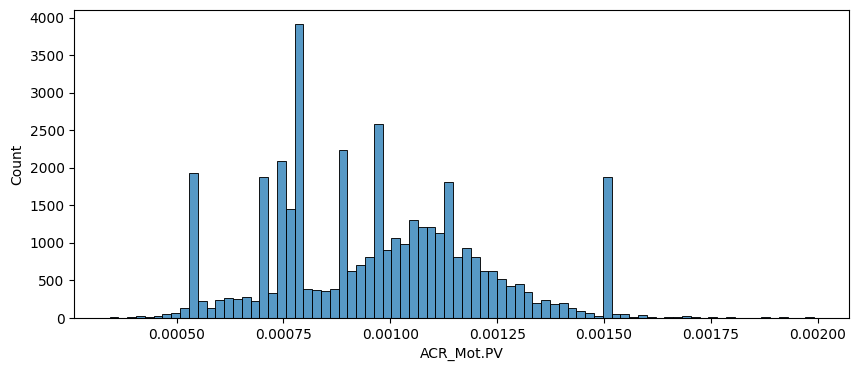

In [ ]:
# So if this data set is all "normal" operational data, what are these spikes? I suppose
#   we have to assume that is plausible in normal operation.
plt.figure(figsize=(10,4))
sns.histplot(data=B_train_df, x='ACR_Mot.PV')
plt.show()

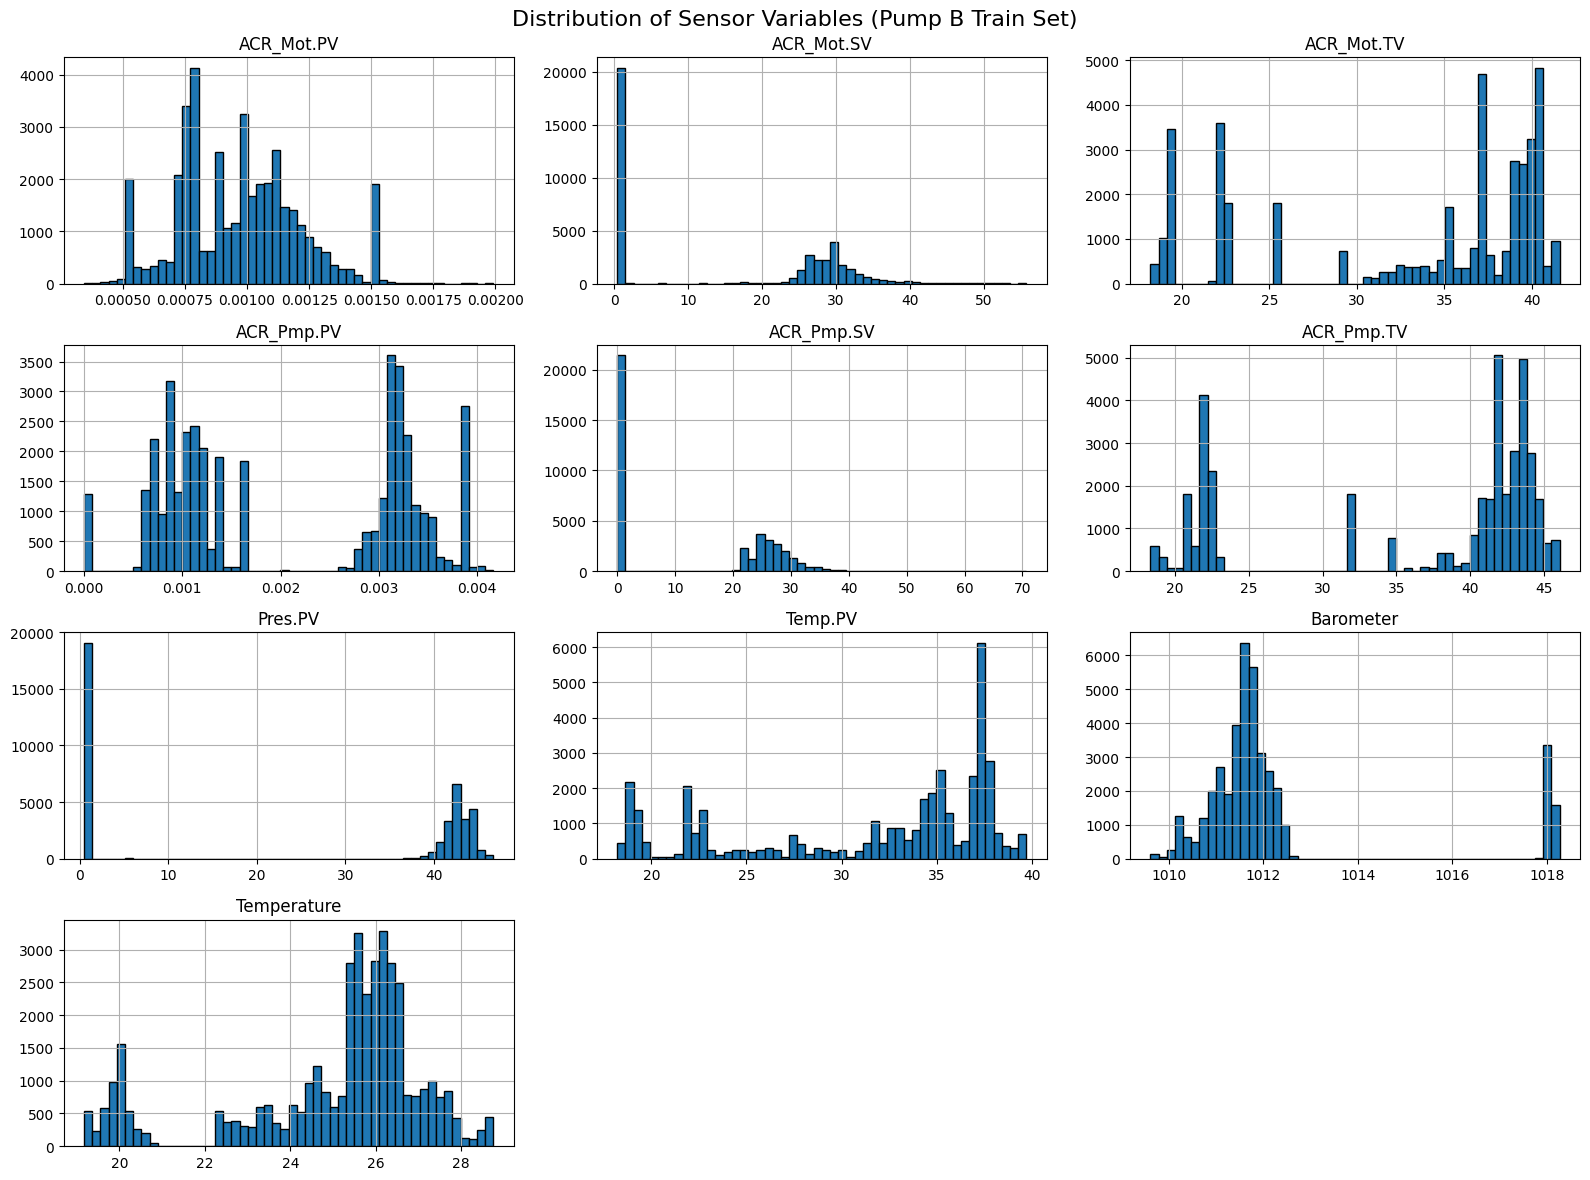

In [159]:
# let's just take a look at the distrobutions of everything.
numeric_cols = B_train_df.select_dtypes(include='number').columns

B_train_df[numeric_cols].hist(
    bins=50,
    figsize=(16, 12),
    layout=(4, 3),
    edgecolor='black'
)

plt.suptitle("Distribution of Sensor Variables (Pump B Train Set)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Phew, first thoughts here: Multimodal, and bimodal distributions, possibly like a startup
# or ramp-up of machinary? 0 spikes are strange here, I think these
# can be interpreted as missing data. Like a sensor offline instance. Maybe the imputation 
# plan has changed.

# Another thought for a feature here would be something like a "sensor data missing field?"
# I've used a similar idea for a project, and that actually helped the model in the end.

# Will need to dig in and try to get some additional understanding on if that's the right
# idea for this specific project and sensor data as a whole.